<a href="https://colab.research.google.com/github/dwgb93/SIAM-Neural-Nets/blob/main/Baby's_Third_Neural_Network_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#My First Neural Network: Autoencoders

Convolutional neural nets are great, but they take a lot of time to run. One thing we can do reduce the dimension of our data from 28x28 down to a much smaller latent space.

We can then classify numbers in their latent space, and recover an approximation of the original data using a decoder.

This is the basis of how some Generative Adversarial Networks (GANs) work, for synthesizing new data.

Once again: bookkeeping

In [13]:
import numpy as np
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import time

Next we'll download the data we are going to use

In [2]:
# the data is already split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Each pixel is a value from 0 to 255, so we normalize it to 0 to 1. 
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


11493376/11490434 [==============================] - 0s 0us/step


An autoencoder is made of two parts: an _encoder_ and a _decoder_. The function below ```create_autoencoders()``` returns the following parts as separate models:

- The encoder 
- the decoder
- the complete model, when the encoder and decoder are joined in one model.

In [3]:
def create_autoencoders(feature_layer_dim = 16):
  # This is yet another way Keras lets us define a neural network.
  input_img = Input(shape = (784,), name = 'Input_Layer')
  # The layer encoded has a dimension equal to feature_layer_dim and contains
  # the encoded input (therefore the name)
  encoded = Dense(feature_layer_dim, activation = 'relu', name = 'Encoded_Features')(input_img)
  decoded = Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)

  encoded_input = Input(shape = (feature_layer_dim,))
  decoder = autoencoder.layers[-1]
  decoder = Model(encoded_input, decoder(encoded_input))

  return autoencoder, encoder, decoder

So let's create our first autoencoder, with 8 features in our latent space.

In [26]:
autoencoder, encoder, decoder = create_autoencoders(8)

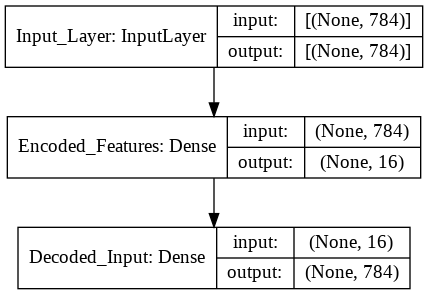

In [27]:
keras.utils.plot_model(autoencoder, show_shapes=True)

Autoencoders are like any other neural network we've been dealing with

 **define** (done) -> **compile** -> **fit**


In [28]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Now, let's train our autoencoder.

All we're doing is going through the network and converting each image from a vector of length 784 to a vector of length 8, then trying to recreate the original data.

In [29]:
autoencoder.fit(x_train, x_train, epochs=30, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose = 1)

Epoch 1/30
235/235 [==============================] - 3s 12ms/step - loss: 0.4154 - val_loss: 0.2232
Epoch 2/30
235/235 [==============================] - 3s 11ms/step - loss: 0.2115 - val_loss: 0.1824
Epoch 3/30
235/235 [==============================] - 3s 11ms/step - loss: 0.1784 - val_loss: 0.1634
Epoch 4/30
235/235 [==============================] - 3s 11ms/step - loss: 0.1618 - val_loss: 0.1518
Epoch 5/30
235/235 [==============================] - 2s 10ms/step - loss: 0.1513 - val_loss: 0.1453
Epoch 6/30
235/235 [==============================] - 3s 11ms/step - loss: 0.1454 - val_loss: 0.1417
Epoch 7/30
235/235 [==============================] - 3s 11ms/step - loss: 0.1425 - val_loss: 0.1391
Epoch 8/30
235/235 [==============================] - 3s 11ms/step - loss: 0.1396 - val_loss: 0.1371
Epoch 9/30
235/235 [==============================] - 3s 11ms/step - loss: 0.1382 - val_loss: 0.1353
Epoch 10/30
235/235 [==============================] - 3s 11ms/step - loss: 0.1359 - val_lo

Let's encode and decode the test images now.

In [30]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

#Image reconstruction

Now that we've come up with an encoding scheme, let's try and reconstruct the images

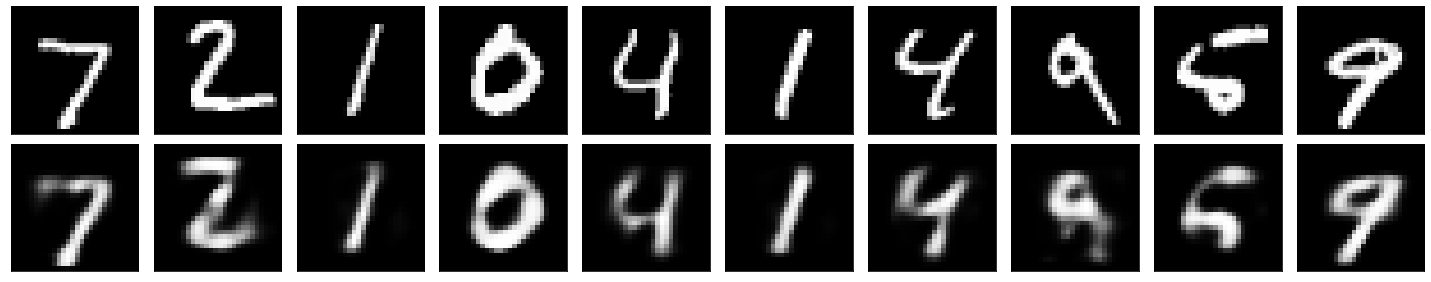

In [31]:
n = 10 # how many digits we will display

fig = plt.figure(figsize=(20, 4))
for i in range(n):  
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()


Not great. What happens if we increase the number of latent features?

Let's try n = 64.

What about n = 16?

As we can see, it only takes a small latent space to generate realiztic reconstructions.

Can we use these encoded latent space to make predictions? Let's find out!

In [32]:
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)

This is the same as the first neural network, but where we input encoded images instead of all 784 pixels.

In [23]:
model = keras.Sequential()
model.add(keras.layers.Dense(16, activation="relu", input_shape=(len(encoded_train[0]),)))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(10, activation="softplus"))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(encoded_train, y_train, epochs=20)

model.evaluate(encoded_test,  y_test, verbose=2)

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 1.8667 - accuracy: 0.2490
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.7281 - accuracy: 0.7605
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5862 - accuracy: 0.8125
Epoch 4/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5459 - accuracy: 0.8293
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5063 - accuracy: 0.8407
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4771 - accuracy: 0.8499
Epoch 7/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4740 - accuracy: 0.8540
Epoch 8/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4528 - accuracy: 0.8589
Epoch 9/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4481 - accuracy: 0.8633
Epoch 10/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.445

[0.269035667181015, 0.9200000166893005]

I can't believe that actually worked. That's nearly the same accuracy we got the first time around, but on a network 10x smaller.

This is usually used in applications like k-Nearest Neighbours, which can experience close to a 1000x speedup when using encoded data enstead of full data, with only minimal loss in accuracy.

In [14]:
# Don't bother running this one. It takes more than 15 minutes.

from sklearn.neighbors import KNeighborsClassifier 

start = time.time()
knn = KNeighborsClassifier(n_neighbors = 7).fit(x_train, y_train) 
# accuracy on X_test 
print("Accuracy:", knn.score(x_test, y_test) , "%")

end = time.time()
print("Time:", end - start, "seconds")

Accuracy: 0.9694 %
Time: 1005.5792689323425 seconds


In [33]:
start = time.time()
knn = KNeighborsClassifier(n_neighbors = 7).fit(encoded_train, y_train) 
# accuracy on X_test 
print("Accuracy:", knn.score(encoded_test, y_test) , "%")

end = time.time()
print("Time:", end - start, "seconds")

Accuracy: 0.9535 %
Time: 8.79640531539917 seconds


We get close to 1000x faster with n = 8, but lose a lot of accuracy.

n = 64 is still 10x faster, with almost no loss of accuracy though.

n = 16 is a sweet spot, more than 100x faster, with only 1.5% loss of accuracy

But what if we want to generate images on our own?

#Bonus Section: GANs

#Generative Adversarial Networks

The following code was provided in MA797: Applications of Machine Learning, which is taught by Dr. Flores and Dr. Tran in the Fall.

(I modified the generator and discriminator)

In [47]:
from __future__ import print_function, division
import matplotlib
matplotlib.use('Agg') #for using matplotlib remotely on the GPU workstation
from keras.datasets import mnist #note that we are using the mnist data
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np


#define the DCGAN class
class DCGAN():
    #define the initial default parameters
    #to change these defaults, just do it when you call the DCGAN class
    #for example, dcganrun = DCGAN(img_rows=64,img_cols=64,channels=3)
    def __init__(self,img_rows=28,
                 img_cols=28,
                 channels=1,
                 latent_dim=100):
        # Input shape and channels
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim
        #Choose the optimizer
        optimizer = Adam(0.0002, 0.5)

        #The following 30 lines or so make the DCGAN computational graph
        #It is composed of a random input z that goes into a generator.
        #The output of the generator is then the input to the discriminator.
        #The combined model only trains the generator

        # Build and compile the discriminator, see function build_discriminator() below
        #Note that the discriminator object is a keras model, so you can
        #call functions that you would normally use for a keras model
        #such as .compile(), or .trainable, see keras documentation
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        # We will make the combined model about 10 lines down, and
        # when we do it we will want to fix the disciminator weights.
        # Note that this is how we inform the generator to make realistic images.
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid) #note that, at this point:
                                        #valid = disciminator(generator(z))
        #compile the combined model
        self.model_checkpoint = ModelCheckpoint('saved_model/combinedmodel.hdf5', monitor='accuracy', save_best_only=True, save_freq="epoch")
        self.callbacks_list=[self.model_checkpoint]

        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
        self.combined.summary()

    #the function to build the generator as a sequential model
    #it takes as input the random noise vector
    #then uses upsampling followed by Conv2d to upsample
    #note that this was found to improve results over just using Conv2dtranspose
    #also note the use of tanh in the last layer and batchnorm after the conv2ds,
    #except for the last layer
    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    #build the disciminator
    #note the use of leakyReLU and dropout
    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same")) #output is 14x14
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25)) #i found a suggestion to use dropout in the disciminator
                                 #to prevent it from learning too quickly for the generator to learn anything
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same")) #output is 7x7
        #model.add(ZeroPadding2D(padding=((0,1),(0,1)))) #this pads by 1 on the bottom and right
                                                        #to make it an 8x8
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same")) #output is 4x4
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #model.add(Conv2D(256, kernel_size=3, strides=2, padding="same")) #output is 4x4
        #model.add(BatchNormalization(momentum=0.8))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Flatten()) #flatten into a vector
        model.add(Dense(1, activation='sigmoid')) #output is a single number between 0 and 1

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    #function to train the model, default batch size is 128
    def train(self, epochs, batch_size=128, save_interval=1000):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data() #mnist has its own loading function, nice!

        # Rescale -1 to 1, note that 255/127.5=2, then subtract 1 to get a max of 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3) #convolutional layers expect 4d tensors in tensorflow

        # Adversarial ground truths, i.e., labels
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample N(0,1) noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise) #note that since we are generating fake data from the generator, we don't effect the disciminator weights

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid) #first half of GAN loss, corresponds to real images
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)#second half of GAN loss, corresponds to fake images
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #total GAN loss

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.fit(noise, valid, callbacks=self.callbacks_list)
            #note that you use valid labels here, since we want these fake images to look real

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss.history['loss'][0]))

            # If at save interval => save generated image samples
            if (epoch + 1) % save_interval == 0:
                self.save_imgs(epoch)

    #function for saving images
    def save_imgs(self, epoch):
        r, c = 5, 5 #number of rows and columns for the plot of fake images, so 25 total fake images
        noise = np.random.normal(0, 1, (r * c, self.latent_dim)) #generate the random noise
        gen_imgs = self.generator.predict(noise) #pass the noise through the trained generator

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        #plot images in 5x5 plot
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/images/mnist_%d.png" % epoch)
        plt.close()



In [48]:
dcgan = DCGAN() #make a DCGAN class object

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_100 (Bat (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 7, 7, 64)        

In [49]:
dcgan.train(epochs=20000, batch_size=32, save_interval=1000) #train it and save images every 500 epochs

Streaming output truncated to the last 5000 lines.
5953 [D loss: 0.000082, acc.: 100.00%] [G loss: 0.074460]
1/1 [==============================] - 0s 11ms/step - loss: 0.0341 - accuracy: 1.0000
5954 [D loss: 0.000136, acc.: 100.00%] [G loss: 0.034075]
1/1 [==============================] - 0s 11ms/step - loss: 0.0561 - accuracy: 1.0000
5955 [D loss: 0.000383, acc.: 100.00%] [G loss: 0.056134]
1/1 [==============================] - 0s 12ms/step - loss: 0.0421 - accuracy: 1.0000
5956 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.042121]
1/1 [==============================] - 0s 11ms/step - loss: 0.0888 - accuracy: 0.9688
5957 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.088809]
1/1 [==============================] - 0s 11ms/step - loss: 0.0579 - accuracy: 1.0000
5958 [D loss: 0.000141, acc.: 100.00%] [G loss: 0.057905]
1/1 [==============================] - 0s 11ms/step - loss: 0.0811 - accuracy: 0.9688
5959 [D loss: 0.000142, acc.: 100.00%] [G loss: 0.081102]
1/1 [======================

KeyboardInterrupt: ignored